## Tips to speed up Python
[Luke Conibear](https://www.lukeconibear.com/)  
l.a.conibear@leeds.ac.uk  

- [Python](#Python)
- [Hang on, don't optimise too early](#Hang-on,-don't-optimise-too-early)
- [How fast is it?](#How-fast-is-it?)
- [How fast could it go?](#How-fast-could-it-go?)
- [Potential improvements](#Potential-improvements)
  - [Append to lists, rather than concatenating](#Append-to-lists,-rather-than-concatenating)
  - [Move loop-invariants outside loops](#Move-loop-invariants-outside-loops)
  - [Use built-in functions](#Use-built-in-functions)
  - [Use suitable/optimal/specialised data structures](#Use-suitable/optimal/specialised-data-structures)
  - [Reduce repeated calculations with caching](#Reduce-repeated-calculations-with-caching)
  - [Use vectorisation instead of loops](#Use-vectorisation-instead-of-loops)
  - [Algorithm improvements](#Algorithm-improvements)
  - [Compilers](#Compilers)
  - [Lazy loading and execution](#Lazy-loading-and-execution)
  - [Parallelisation](#Parallelisation)
    - [Single machine](#Single-machine)
    - [Multi-threading](#Multi-threading)
    - [Multi-processing](#Multi-processing)
    - [Interactive on HPC](#Interactive-on-HPC)
    - [HPC](#HPC)
  - [GPUs](#GPUs)
- [Recommendations](#Recommendations)
- [Further information](#Further-information)

### Python
- High−level
  - Clean, readable, and efficient.
  - Easy and fun to learn.
- Dynamic
  - Fast to write and test code.
  - Less code.
  - Flexible (interactive).
- Great support
  - Open source.
  - Vast range of libraries.
  - Huge number of users.
- Slow (sometimes)
  - Dynamic, CPython - [reasons why later](#Compilers).

### Hang on, don't optimise too early
- Trade-offs e.g. complexity, speed, memory, disk, readability, time, effort, etc.
1. Check that code is correct (tested, documented).
2. Is optimisation really needed?
3. If yes, then try simpler things first (e.g. data structures, vectorisation, etc.).
4. Then try more advanced ones (e.g. compilers, parallelisation, etc.).

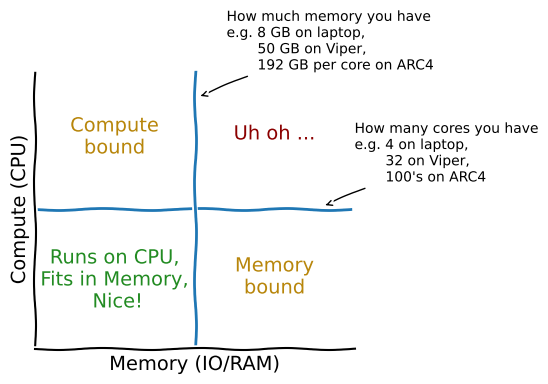

In [88]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    plt.axhline(y=0.5, linestyle='-')
    plt.axvline(x=0.5, linestyle='-')
    ax.annotate('Compute\nbound', xy=(0.25, 0.7), ha='center', color='darkgoldenrod')
    ax.annotate('Memory\nbound', xy=(0.75, 0.2), ha='center', color='darkgoldenrod')
    ax.annotate('Runs on CPU,\nFits in Memory,\n Nice!', xy=(0.25, 0.15), ha='center', color='forestgreen')
    ax.annotate('Uh oh ...', xy=(0.75, 0.75), ha='center', color='darkred')
    ax.annotate(
        "How many cores you have\ne.g. 4 on laptop,\n       32 on Viper,\n       100's on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.9, 0.51),
        xytext=(1, 0.6),
        fontsize=10
    )
    ax.annotate(
        "How much memory you have\ne.g. 8 GB on laptop,\n       50 GB on Viper,\n       192 GB per core on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.51, 0.9),
        xytext=(0.6, 1),
        fontsize=10
    )
    ax.set_xlabel('Memory (IO/RAM)')
    ax.set_ylabel('Compute (CPU)')
    plt.show()

### How fast is it?
- [Profiling](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)
  - [Speed](https://github.com/pyutils/line_profiler)
    - [IPython magic](https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html) (Jupyter Lab)
      - Line: `%timeit`
      - Cell: `%%timeit`
      - If `pip install line_profiler`:
        - First load module: `%load_ext line_profiler`
        - Scripts: `%prun`
        - Line-by-line: `%lprun`
          - `@profile` decorator around the function
  - [Memory](https://github.com/pythonprofilers/memory_profiler)
    - If `pip install memory_profiler`:
    - First load module:
      - `%load_ext memory_profiler`
      - Line: `%memit`
      - Cell: `%%memit`
      - Line-by-line: `%mprun`

### How fast could it go?
- Time-space complexity
  - [Big O notation](https://www.bigocheatsheet.com/) both for time and space.
  - Order of operations, O(...), (not the exact time of the operation).
  - Important for large number of elements (not for few).
  - Can consider typical (often), worst (limiting, asymtopic), or best case scenario.
  - Ignores constants and takes the largest order, so O(2n<sup>2</sup> + 3n) would be O(n<sup>2</sup>).
  - Constant time means per machine operation.
  - Identify what N is e.g. elements in array.
    - Could have multiple parameters e.g. O(n + m + k).

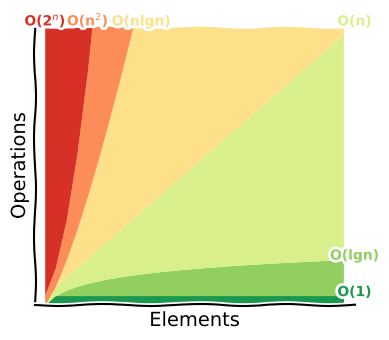

In [4]:
max_value = 30
elements = np.arange(1, max_value)

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, max_value])
    ax.set_xlim([0, max_value])
    ax.set_xlabel('Elements')
    ax.set_ylabel('Operations')
    
    complexities = ['O(1)', 'O(lgn)', 'O(n)', 'O(nlgn)', 'O(n$^2$)', 'O(2$^n$)']
    colours = list(reversed(['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']))
    x_values = [max_value, max_value, max_value, max_value / 3, max_value / 6, max_value / max_value]
    y_values = [max_value / max_value, np.log2(max_value), max_value, max_value, max_value, max_value]
    y_lows = [0, 1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2]
    y_highs = [1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2, max_value]
    
    for index, complexity in enumerate(complexities):
        plt.fill_between(elements, y_lows[index], y_highs[index], facecolor=colours[index])
        ax.annotate(complexity, xy=(x_values[index], y_values[index]), ha='center', color=colours[index], fontsize=10, weight='bold')
    
    plt.show()

### Potential improvements
*Reasons*

#### Append to lists, rather than concatenating
- *Because lists (dynamic arrays) are allocated twice the memory required, so appending fills this space up until size limit is reached - O(1) over long-term average (amortisation).*
- *While concatenating to them creates a new list each time - O(n).*

In [35]:
%%timeit
my_list = []
for num in range(1_000):
    my_list += [num] # time O(n)

46.6 µs ± 885 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
%%timeit
my_list = []
for num in range(1_000):
    my_list.append(num) # time O(1)

34.9 µs ± 211 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Move loop-invariants outside loops
- *Quantities/calculations that don't vary with each cycle can be moved outside of the loop to avoid duplicating type-checking/calculations.*

In [37]:
%%timeit
for num in range(1_000_000):
    constant = 500_000
    bigger_num = max(num, constant)

122 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit
constant = 500_000
for num in range(1_000_000):
    bigger_num = max(num, constant)

116 ms ± 900 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Use [built-in functions](https://docs.python.org/3/library/functions.html)
- *Optimised in [C](https://en.wikipedia.org/wiki/C_(programming_language) (statically typed and compiled).*

In [39]:
nums = [num for num in range(1_000_000)]

In [40]:
%%timeit
count = 0
for num in nums: # time O(n)
    count += 1

23.8 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit len(nums) # time O(1)

41.7 ns ± 0.364 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


#### Use suitable/optimal/specialised [data structures](https://docs.python.org/3/tutorial/datastructures.html)
- [Additional data structures](https://docs.python.org/3/library/collections.html).
- e.g. [tuples](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) use less memory (than lists).
  - *Tuples are immutable (fixed), do not over-allocate, and do not have pointers.*
  - [Named-tuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) variant with field attribute look-up.

In [95]:
my_list  = [1, 2, 3]
my_tuple = (1, 2, 3)

import sys

print(f'my_list  is {sys.getsizeof(my_list)} bytes')
print(f'my_tuple is {sys.getsizeof(my_tuple)} bytes')

my_list  is 80 bytes
my_tuple is 64 bytes


- e.g. [dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) use less time (than lists).
  - *Dictionaries (hash tables) hash keys (arrays) to values (linked lists).*
  - *Both keys and values can be any arbitrary objects.*
  - *The hashed keys are indexed and can be searched in O(1).*
  - Can use more memory (though [ordered dictionaries](https://docs.python.org/3/library/collections.html#collections.OrderedDict) are more memory efficient).

In [46]:
import numpy as np

haystack_list = np.random.uniform(low=0, high=100, size=(1_000_000))

haystack_dict = {key: value for key, value in enumerate(haystack_list)}

needles = [0.1, 50.1, 99.1]

In [48]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_list: # time O(n) within list
        needles_found += 1

523 µs ± 9.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_dict: # time O(1) within dict
        needles_found += 1

153 ns ± 0.575 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


- Many more examples (e.g. sets for membership testing, generators save memory by yielding only the next iteration, 32 bit floats use less memory than 64 bit floats, other data structures such as binary search trees, graphs, heaps, linked lists, etc.).

#### Reduce repeated calculations with [caching](https://realpython.com/lru-cache-python/)
- [Memoisation](https://en.wikipedia.org/wiki/Memoization)
- Example below is for the [Fibonacci sequence](https://en.wikipedia.org/wiki/Fibonacci_number), where each number is the sum of the two preceding ones starting from 0 and 1 e.g. 0, 1, 1, 2, 3, 5, 8, 13, 21, 34.
- *The brute force version of fibonacci takes O(2^n) time as there are 2 calls to the function n times (a balanced tree of repeated calls).*
- *The cached version of fibonacci takes O(n) time as there is 1 call to the function for each value of n.*
- *(Note the space complexity is O(n) in both cases, as recursion places n calls to the function on the call stack, also there is a dictionary of size n in the cached version).*

In [54]:
def fibonacci(n): # time O(2^n)
    if n == 0 or n == 1:
        return 0
    elif n == 2:
        return 1
    
    return fibonacci(n - 1) + fibonacci(n - 2)

In [55]:
%timeit fibonacci(20)

1.05 ms ± 8.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
def fibonacci_with_caching(n, cache={0: 0, 1: 0, 2: 1}): # time O(n)
    if n in cache:
        return cache[n]
    else:
        cache[n] = fibonacci_with_caching(n - 1, cache) + fibonacci_with_caching(n - 2, cache)
        return cache[n]

In [57]:
%timeit fibonacci_with_caching(20, cache={0: 0, 1: 0, 2: 1})

4.16 µs ± 34.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


#### Use [vectorisation](https://jakevdp.github.io/PythonDataScienceHandbook/02.03-computation-on-arrays-ufuncs.html) instead of loops
- Loops are slow in Python ([CPython](https://www.python.org/), default interpreter).
  - *Because loops type−check and dispatch functions per cycle.*
- [Vectors](https://en.wikipedia.org/wiki/Automatic_vectorization) can work on many parts of the problem at once.
- NumPy [ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html) (universal functions).
  - *Optimised in C (statically typed and compiled).*

In [58]:
nums = np.arange(1_000_000)

In [59]:
%%timeit
for num in nums:
    num *= 2

281 ms ± 7.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
double_nums = np.multiply(nums, 2)

614 µs ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


- [Broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) (ufuncs over different shaped arrays, [NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html), [xarray](https://xarray.pydata.org/en/v0.16.2/computation.html?highlight=Broadcasting#broadcasting-by-dimension-name)).

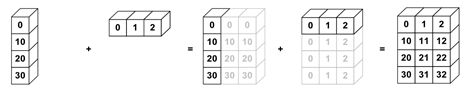

In [62]:
nums_col = np.array([0, 10, 20, 30]).reshape(4, 1)
nums_row = np.array([0, 1, 2])

nums_col + nums_row

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

In [65]:
import xarray as xr

nums_col = xr.DataArray([0, 10, 20, 30], [('col', [0, 10, 20, 30])])
nums_row = xr.DataArray([0, 1, 2], [('row', [0, 1, 2])])

nums_col + nums_row

<xarray.DataArray (col: 4, row: 3)>
array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])
Coordinates:
  * col      (col) int64 0 10 20 30
  * row      (row) int64 0 1 2

#### Algorithm improvements
- The instructions to solve the problem.
  - Free MIT course on '*Introduction to algorithms*', [video lectures](https://youtube.com/playlist?list=PLUl4u3cNGP61Oq3tWYp6V_F-5jb5L2iHb).
- e.g. [sorting](https://en.wikipedia.org/wiki/Sorting_algorithm).
  - Question: Find the two numbers that sum up to the target.
  - So, for array [3, 5, -4, 8, 11, 1, -1, 6] with a target sum of 10, the two numbers that sum up to 10 are 11 and -1.

In [66]:
def two_number_sum_nested_loops(array, target_sum): # time O(n^2), space O(1)
    for index1 in range(len(array)):
        for index2 in range(index1 + 1, len(array)):
            if array[index1] + array[index2] == target_sum:
                return [array[index1], array[index2]]
            
    return []

In [67]:
%timeit two_number_sum_nested_loops([3, 5, -4, 8, 11, 1, -1, 6], 10)

2.31 µs ± 47.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [68]:
def two_number_sum_sorting(array, target_sum): # time O(nlgn), space O(1)
    array.sort()
    left_index = 0
    right_index = len(array) - 1
    while left_index < right_index:
        current_sum = array[left_index] + array[right_index]
        
        if current_sum == target_sum:
            return [array[left_index], array[right_index]]
        elif current_sum < target_sum:
            left_index += 1
        elif current_sum > target_sum:
            right_index -= 1
            
    return []

In [69]:
%timeit two_number_sum_sorting([3, 5, -4, 8, 11, 1, -1, 6], 10)

442 ns ± 4.11 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


- Many more examples (e.g. dynamic programming, greedy algorithms, famous algorithms, recursion, etc.)

#### [Compilers](https://en.wikipedia.org/wiki/Compiler)
- [CPython](https://www.python.org/).
  - *Ahead-Of-Time (AOT) compiler.*
      - Statically compiled C extensions.
      - General purpose interpreter (relatively fast for some of these tasks).
- [PyPy](https://www.pypy.org/)
  - *Just−In−Time (JIT) compiler (written in Python).*
    - Many optimisations.
    - Effective interpreter for numerical tasks with repitition and loops.
    - Replaces CPython and approximately 4.2 times faster.
    - Overheads for start-up (first time running) and memory.
- [Numba](http://numba.pydata.org/)
  - *Uses JIT compiler on NumPy functions.*
  - *Converts to fast machine code (LLVM).*
    - Uses decorators around functions: `@jit`, `@jit(nopython=True)` same as `@njit`, `@jit(nogil=True)`
    - Use with the default CPython.
    - Works well with broadcasting.

In [70]:
from numba import njit

nums = np.arange(1_000_000)

In [71]:
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [73]:
%timeit super_function(nums)

1.64 s ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
@njit # numba decorator
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [77]:
%timeit super_function(nums)

14.8 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### [Lazy loading](https://xarray.pydata.org/en/v0.16.2/dask.html) and [execution](https://tutorial.dask.org/01x_lazy.html)
- Delays loading data into memory and/or executing commands until requested.
- Enables the handling of larger than memory files.
- Lazy execution `.compute()` works well with parellisation (example coming next).
- *Saves time by not having to continually handle large files.*
- [Video example for climate data](https://youtu.be/2rgD5AJsAbE).

In [81]:
xr.tutorial.open_dataset('air_temperature')
#xr.tutorial.load_dataset('air_temperature')

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

#### Parallelisation
- Divide a large problem into many smaller ones and solve simultaneously.
  - *Divides up the time/space complexity.*
  - Multi-processing (cores) - useful for compute-bound problems.
  - Multi-threading (parts of processes), useful for memory-bound problems.
    - Thread switching preemptively controlled by [Global Interpreter Lock, GIL](https://wiki.python.org/moin/GlobalInterpreterLock).
  - Asynchronous, multi-threading, thread switching explicitly and cooperatively controlled, useful for massive scaling.
- How parallelisable is the code?
  - [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law) summarises the theoretical speed up factor from parallelising = 1 / (1 - amount_parallelisable)
  - e.g. if code (all in serial) takes 20 hours
    - if 90% is parallelisable, then theoretical speed up factor = 1 / (1 - 0.90) = 10,  i.e. down to 2 hours (the time for the serial part).
    - if 10% is parallelisable, then theoretical speed up factor = 1 / (1 - 0.10) = 1.1, i.e. down to 18 hours (the time for the serial part).
- If need to share memory across chunks
  - Use [shared memory](https://docs.dask.org/en/latest/shared.html), commonly OpenMP (Open Multi-Processing).
  - `-pe smp np` on ARC4
- Otherwise
  - Use [message passing interface, MPI](https://docs.dask.org/en/latest/setup/hpc.html?highlight=mpi#using-mpi), commonly OpenMPI.
  - `-pe ie np` on ARC4

##### [Single machine](https://docs.dask.org/en/latest/setup/single-distributed.html)
- [Dask](https://docs.dask.org/en/latest/)
  - Great documentation.
  - Simplifies parallelising Python code using familiar API.
  - Swap out for Numpy arrays or Pandas DataFrames.
  - Under the hood for many libraries e.g. xarray, iris, scikit-learn.
  - [Coiled](https://coiled.io/about/) is a spin-off for increasing access to Dask.
- e.g. [xarray](http://xarray.pydata.org/en/stable/dask.html)

In [82]:
from IPython.display import Video

In [83]:
Video('dask_single_machine.mp4')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
ds = xr.open_dataset(
    '/nfs/a68/shared/earlacoa/wrfout_2015_PM_2_DRY_0.25deg.nc',
    chunks={'time': 'auto'} # dask chunks
)

In [ ]:
ds.nbytes * (2 ** -30)

In [ ]:
%time ds_mean = ds.mean()

In [ ]:
%time ds_mean.compute()

In [ ]:
ds.close()
client.close()

##### Multi-threading
- e.g. [dask.array](https://examples.dask.org/array.html)
  - Similar to NumPy arrays / API.

In [84]:
Video('multi-threading.mp4')

In [ ]:
from dask.distributed import Client
client = Client(
    processes=False,
    threads_per_worker=4,
    n_workers=1
)
client

In [ ]:
import dask.array as da

In [ ]:
my_array = da.random.random(
    (50_000, 50_000),
    chunks=(5_000, 5_000) # dask chunks
)
result = my_array + my_array.T
result

In [ ]:
result.compute()

In [ ]:
client.close()

##### Multi-processing
- e.g. [dask.dataframe](https://examples.dask.org/dataframe.html)
  - Similar to Pandas dataframes / API.

In [85]:
Video('multi-processing.mp4')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
import dask
import dask.dataframe as dd

In [ ]:
df = dask.datasets.timeseries()
df

In [ ]:
type(df)

In [ ]:
result = df.groupby('name').x.std()
result

In [ ]:
result.visualize()

In [ ]:
result_computed = result.compute()

In [ ]:
type(result_computed)

In [ ]:
client.close()

##### [Interactive on HPC](https://pangeo.io/setup_guides/hpc.html)
- e.g. [dask.bag](https://examples.dask.org/bag.html)
  - Iterators over a collection of independent objects.
  - Embarrassingly parallel.
- [Video instructions](https://youtu.be/FXsgmwpRExM).
  - Create or edit the `~/.config/dask/jobqueue.yaml` file with that in this directory.
  - Also, can check the `~/.config/dask/distributed.yaml` file with that in this directory.

In [86]:
Video("interactive_on_hpc.mp4")

In [ ]:
# in a terminal

# log onto arc4
ssh ${USER}@arc4.leeds.ac.uk

# start an interactive session on a compute node on arc4
qlogin -l h_rt=04:00:00 -l h_vmem=12G

# activate your python environment
conda activate my_python_environment

# echo back the ssh command to connect to this compute node
echo "ssh -N -L 5555:`hostname`:5555 -L 5757:`hostname`:5757 ${USER}@arc4.leeds.ac.uk"

# launch a jupyter lab session on this compute node
jupyter lab --no-browser --ip=`hostname` --port=5555

In [ ]:
# in a local terminal
# ssh into the compute node
ssh -N -L 5555:`hostname`:5555 -L 5757:`hostname`:5757 ${USER}@arc4.leeds.ac.uk

In [ ]:
# open up a local browser (e.g. chrome)
# go to the jupyter lab session by pasting into the url bar
localhost:5555
    
# can also load the dask dashboard in the browser at localhost:5757

In [ ]:
# now the jupyter code
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = Client(
    walltime='01:00:00',
    memory='4 G',
    resource_spec='h_vmem=4G',
    scheduler_options={
        'dashboard_address': ':5757',
    },
)

client = Client(cluster)

In [ ]:
cluster.scale(jobs=20)

In [ ]:
client

In [ ]:
import numpy as np
import dask.bag as db

In [ ]:
nums = np.random.randint(low=0, high=100, size=(5_000_000))
nums

In [ ]:
def weird_function(nums):
    return chr(nums)

In [ ]:
bag = db.from_sequence(nums)
bag = bag.map(weird_function)
bag.visualize()

In [ ]:
result = bag.compute()

In [ ]:
client.close()
cluster.close()

##### [HPC](https://docs.dask.org/en/latest/setup/hpc.html)
- Non-interactive.
- Create/edit the `dask_on_hpc.py` file.
- Submit to the queue using `qsub dask_on_hpc.bash`.

#### GPUs
- Graphics Processing Units.
- *Faster than CPUs as specifically optimised for numerical operations, while CPUs perform general computation.*
- Not for IO-bound problems.
- [cuPy](https://cupy.dev/).
  - Works well with NumPy, similar API.
```python
import cupy as cp
x = cp.arange(6).reshape(2, 3).astype('f')
x.sum(axis=1)
```
- [cuDF](https://docs.rapids.ai/api/cudf/stable/).
  - Works well with Pandas, similar API.
- Can run in [parallel](https://docs.dask.org/en/latest/gpu.html).
  - GPUs available on [ARC4](https://arcdocs.leeds.ac.uk/systems/arc4.html#using-the-v100-gpu-nodes).

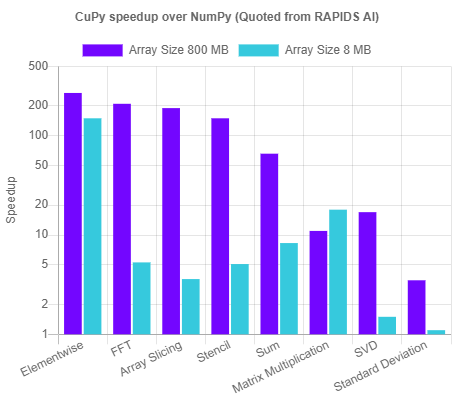

### Recommendations
Once code is correct and optimisation is needed:
1. Profile your code to find what takes up the most time / memory.
  - Within a cell in Jupyter Lab: `%%timeit` and `%%memit`.
  - Line-by-line over a function to find the bottleneck: `line_profiler`, `@profile` decorator, and `%lprun`.
2. Try optimisations from simple to complex:
    - Use the optimal data structures for your problem.
    - Use existing libraries when can that are already optimised (computationally and algorithmically).
    - Use broadcasting/vectorisation (instead of loops where can).
    - Lazy loading and execution.
    - Statically type and compile NumPy functions with Numba.
    - Parallelise suitable and large problems.
      - Use multi-processing with OpenMPI (don't need to worry about GIL).
      - Use Dask.
      - Use embarrassingly parallel code for independent problems (e.g. dask.bag).
      - Use interactively via Jupyter Lab on a HPC.
    - If numerically intensive problem, consider PyPy and/or GPUs.

### Further information
- [Anthony Shaw - Why is Python slow?](https://youtu.be/I4nkgJdVZFA), PyCon 2020. CPython Internals [book](https://realpython.com/products/cpython-internals-book/).
- [Pangeo](https://pangeo.io/index.html) - Python libraries that work well together and build on each other, especially for big data geosciences (e.g. NumPy, Pandas, xarray, iris, Dask, Numba, Jupyter).
- Luciano Ramalho, [*Fluent Python, Clear, Concise, and Effective Programming*](https://www.oreilly.com/library/view/fluent-python/9781491946237/), 2015. O'Reilly Media, Inc.
- Jake VanderPlas, [*Python Data Science Handbook*](https://www.oreilly.com/library/view/python-data-science/9781491912126/), 2016. O'Reilly Media, Inc.